In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Importing Packages
import seaborn as sns
import math 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For specifying the axes tick format 
from scipy.stats import norm, skew #for some statistics
from scipy import stats

#Reading Data
telecom_cust = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')        

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


<a id="section-one"></a>
# 1. Introduction
## a. Problem Statement
Every time a client leaves a business, it represents a significant investment lost. Being able to predict when a client is likely to leave, and offer them incentives to stay, can offer huge savings to a business. Also, understanding what keeps customers engaged is extremely valuable knowledge, as it can be used to develop retention strategies. 

Here we need to know: “Is this customer going to leave us?” Yes or No? 
It is a **binary classification task**.

## b. Data description
Each row represents a customer; each column contains the following customer’s attributes:
* **customerID** : Customer ID
* **gender** : Whether the customer is a male or a female
* **SeniorCitizen** : Whether the customer is a senior citizen or not (1, 0)
* **Partner** : Whether the customer has a partner or not (Yes, No)
* **Dependents** : Whether the customer has dependents or not (Yes, No)
* **tenure** : Number of months the customer has stayed with the company
* **PhoneService** : Whether the customer has a phone service or not (Yes, No)
* **MultipleLines** : Whether the customer has multiple lines or not (Yes, No, No phone service)
* **InternetService** : Customer’s internet service provider (DSL, Fiber optic, No)
* **OnlineSecurity** : Whether the customer has online security or not (Yes, No, No internet service)
* **OnlineBackup** : Whether the customer has online backup or not (Yes, No, No internet service)
* **DeviceProtection** : Whether the customer has device protection or not (Yes, No, No internet service)
* **TechSupport** : Whether the customer has tech support or not (Yes, No, No internet service)
* **StreamingTV** : Whether the customer has streaming TV or not (Yes, No, No internet service)
* **StreamingMovies** : Whether the customer has streaming movies or not (Yes, No, No internet service)
* **Contract** : The contract term of the customer (Month-to-month, One year, Two year)
* **PaperlessBilling** : Whether the customer has paperless billing or not (Yes, No)
* **PaymentMethod** : The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* **MonthlyCharges** : The amount charged to the customer monthly
* **TotalCharges** : The total amount charged to the customer
* **Churn(Target)** : Whether the customer churned or not (Yes or No)

# 2. Exploring the data
## a. Data Profile

In [2]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Sample Value'] = df.loc[0].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2)
    return summary
resumetable(telecom_cust)

Dataset Shape: (7043, 21)


,Name,dtypes,Missing,Uniques,Sample Value,Entropy
0,customerID,object,0,7043,7590-VHVEG,3.85
1,gender,object,0,2,Female,0.30
2,SeniorCitizen,int64,0,2,0,0.19
3,Partner,object,0,2,Yes,0.30
4,Dependents,object,0,2,No,0.27
5,tenure,int64,0,73,1,1.78
6,PhoneService,object,0,2,No,0.14
7,MultipleLines,object,0,3,No phone service,0.41
8,InternetService,object,0,3,DSL,0.46
9,OnlineSecurity,object,0,3,No,0.45


**Entropy** is defined as the randomness or measuring the disorder of the information being processed.

**Action:** 

* Removing customer IDs from the data set as it is unique to every record and we therefore won't use it as a predictor variable.
* Label Encoding all the categorical columns having 2 values.
* Converting Total Charges to a numerical data type.

In [3]:
#Dropping customer ID
cust = telecom_cust.iloc[:,1:].copy()

#Label Encoding
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
cust['Partner'] = le.fit_transform(cust.Partner.values)
cust['Dependents'] = le.fit_transform(cust.Dependents.values)
cust['gender'] = le.fit_transform(cust.gender.values)
cust['PhoneService'] = le.fit_transform(cust.PhoneService.values)
cust['PaperlessBilling'] = le.fit_transform(cust.PaperlessBilling.values)

#Coverting totalCharges to numerical data type.
cust.TotalCharges = pd.to_numeric(cust.TotalCharges, errors='coerce')

**Action :**
Checking for missing values after changing the data type in Total Charges.

In [4]:
#Checking for missing values in TotalCharges
cust.TotalCharges.isna().sum()

11

## b. Handling Missing Values

In [5]:
cust[cust.TotalCharges.isna()][['tenure','MonthlyCharges','TotalCharges','Churn']]

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No


**Observation**: All the new customers(i.e. tenure=0 months) have no total charges data available.

**Action**: We would drop these rows here as all of them have been in the system for less than a month and Customers are marked as churned if they have left the system in the last one month.

In [6]:
#Removing missing values
cust.dropna(inplace = True)

## c. Churn Rate

In [7]:
print("Customer Churn Rate(%):")
print(round(cust['Churn'].value_counts(normalize=True) * 100,2))

Customer Churn Rate(%):
No     73.42
Yes    26.58
Name: Churn, dtype: float64


# 3. Analyzing & Preprocessing
## a. Identifying correlation with Churn
* Convert the target variable in a binary numeric variable
* Convert all Categorical variables into dummy variables

In [8]:
cust['Churn'].replace(to_replace='Yes', value=1, inplace=True)
cust['Churn'].replace(to_replace='No',  value=0, inplace=True)
cust_dummies = pd.get_dummies(cust)

<AxesSubplot:>

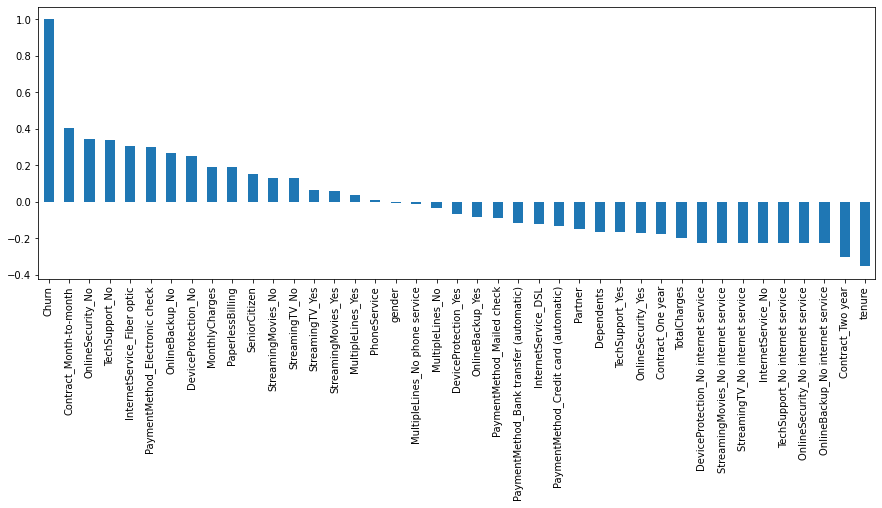

In [9]:
plt.figure(figsize=(15,5))
cust_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

**Observation**:
* Month to month contracts, absence of online security and tech support seem to be positively correlated with churn. 
* Tenure, two year contracts seem to be negatively correlated with churn.
* Interestingly, services such as Online security, Online backup, Tech support and others without internet connection seem to be negatively related to churn.

## b. Analyzing the Numerical Variables
###  Distribution

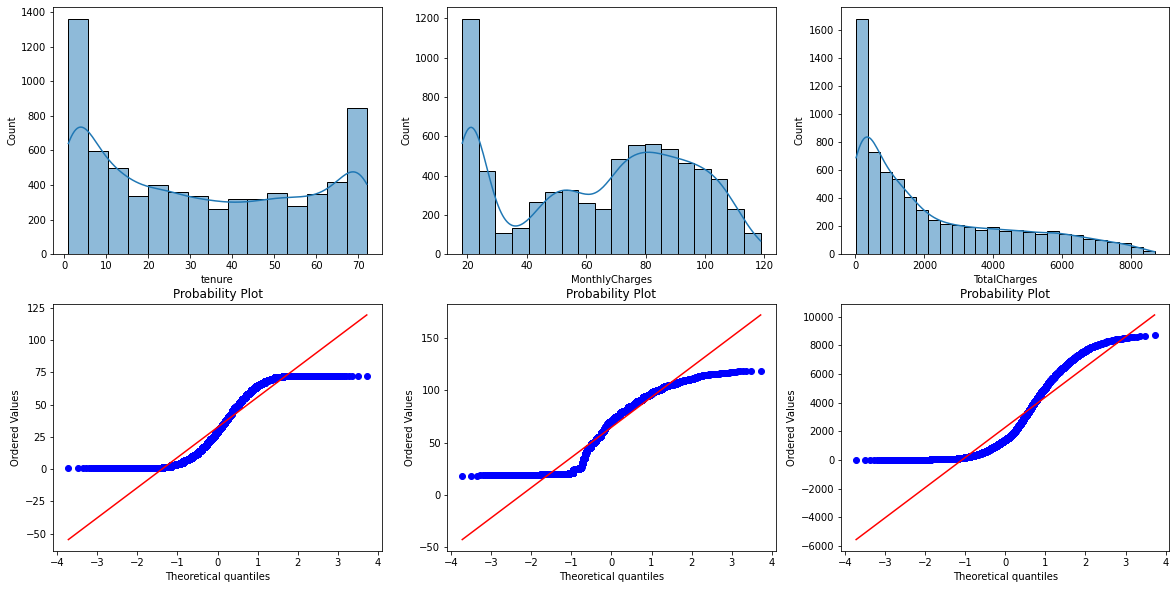

In [10]:
plot , ax = plt.subplots(2 , 3 , figsize = (20 , 10))
g = sns.histplot(cust['tenure'] , kde = True , ax = ax[0][0])
res = stats.probplot(cust['tenure'], plot= ax[1][0])
g = sns.histplot(cust['MonthlyCharges'] , kde = True , ax = ax[0][1])
res = stats.probplot(cust['MonthlyCharges'], plot= ax[1][1])
g = sns.histplot(cust['TotalCharges'] , kde = True , ax = ax[0][2])
res = stats.probplot(cust['TotalCharges'], plot= ax[1][2])

**Observation :**
* Tenure is following a **Bimodal distribution** with peak at 0 & 70.
* MonthlyCharges is following **Edge Peak distribution** with peak at 20 & 80.
* TotalCharges is following **Right Skewed distribution**

These numerical variables are not following a normal distribution. These distributions indicate there are different data distributions present in population data with separate and independent peaks.

**Action :**
* Check if the target variable represents the different distribution present in the data due to presence of different classes.
* Data scaling, As most of the algorithms assume the data to be normally (Gaussian) distributed we can do one of the following:
    * Normalization : Carried for features whose data does not display normal distribution
    * Standardization : Carried out for features that are normally distributed where their values are huge or very small as compared to other features.

### Visualizing against Churn

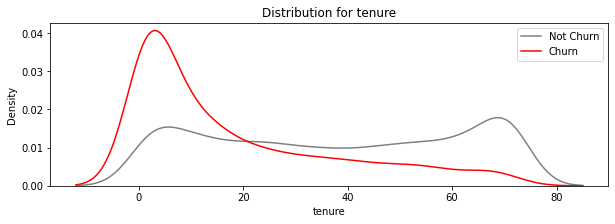

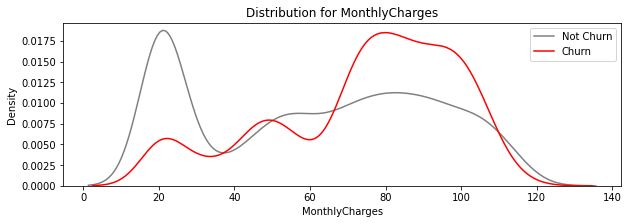

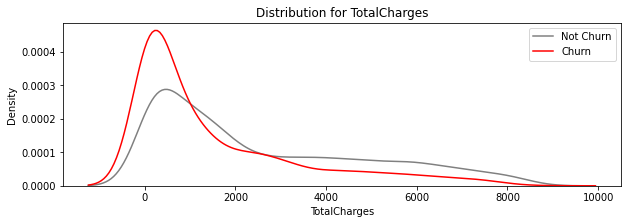

In [11]:
def kdeplot(feature):
    plt.figure(figsize=(10, 3))
    plt.title("Distribution for {}".format(feature))
    ax0 = sns.kdeplot(cust[cust['Churn'] == 0][feature].dropna(), color= 'grey', label= 'Churn: No')
    ax1 = sns.kdeplot(cust[cust['Churn'] == 1][feature].dropna(), color= 'Red', label= 'Churn: Yes')
    ax0.legend(["Not Churn","Churn"],loc='upper right')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

* **Churn by Tenure**: Recent clients are more likely to churn.
* **Churn by Monthly Charges**: Clients with higher MonthlyCharges are more likely to churn.
* **Churn by Total Charges**: It seems that there is higer churn when the total charges are lower.

### Normalization
Tenure, MonthlyCharges and TotalCharges features needs to be normalized as they do not follow a normal distribution.

In [12]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization

cust['tenure'] = mms.fit_transform(cust[['tenure']])
cust['MonthlyCharges'] = mms.fit_transform(cust[['MonthlyCharges']])
cust['TotalCharges'] = mms.fit_transform(cust[['TotalCharges']])

### Outliers

<AxesSubplot:>

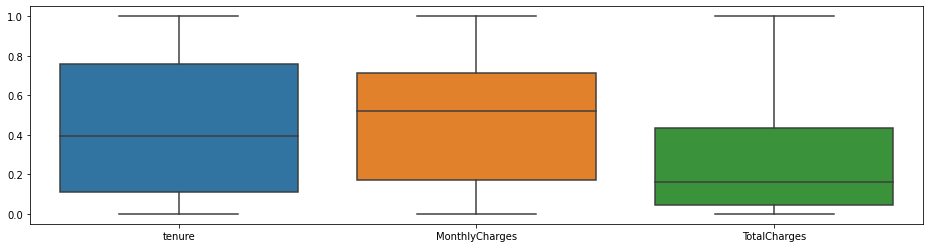

In [13]:
plt.figure(figsize=(16,4))
sns.boxplot(data=cust[['tenure','MonthlyCharges','TotalCharges']])

**Observation :** There are no values present beyond the upper and lower extremes of the Box plots (1.5 x Inter Quartile Range)

## c. Analyzing the Categorical Variables

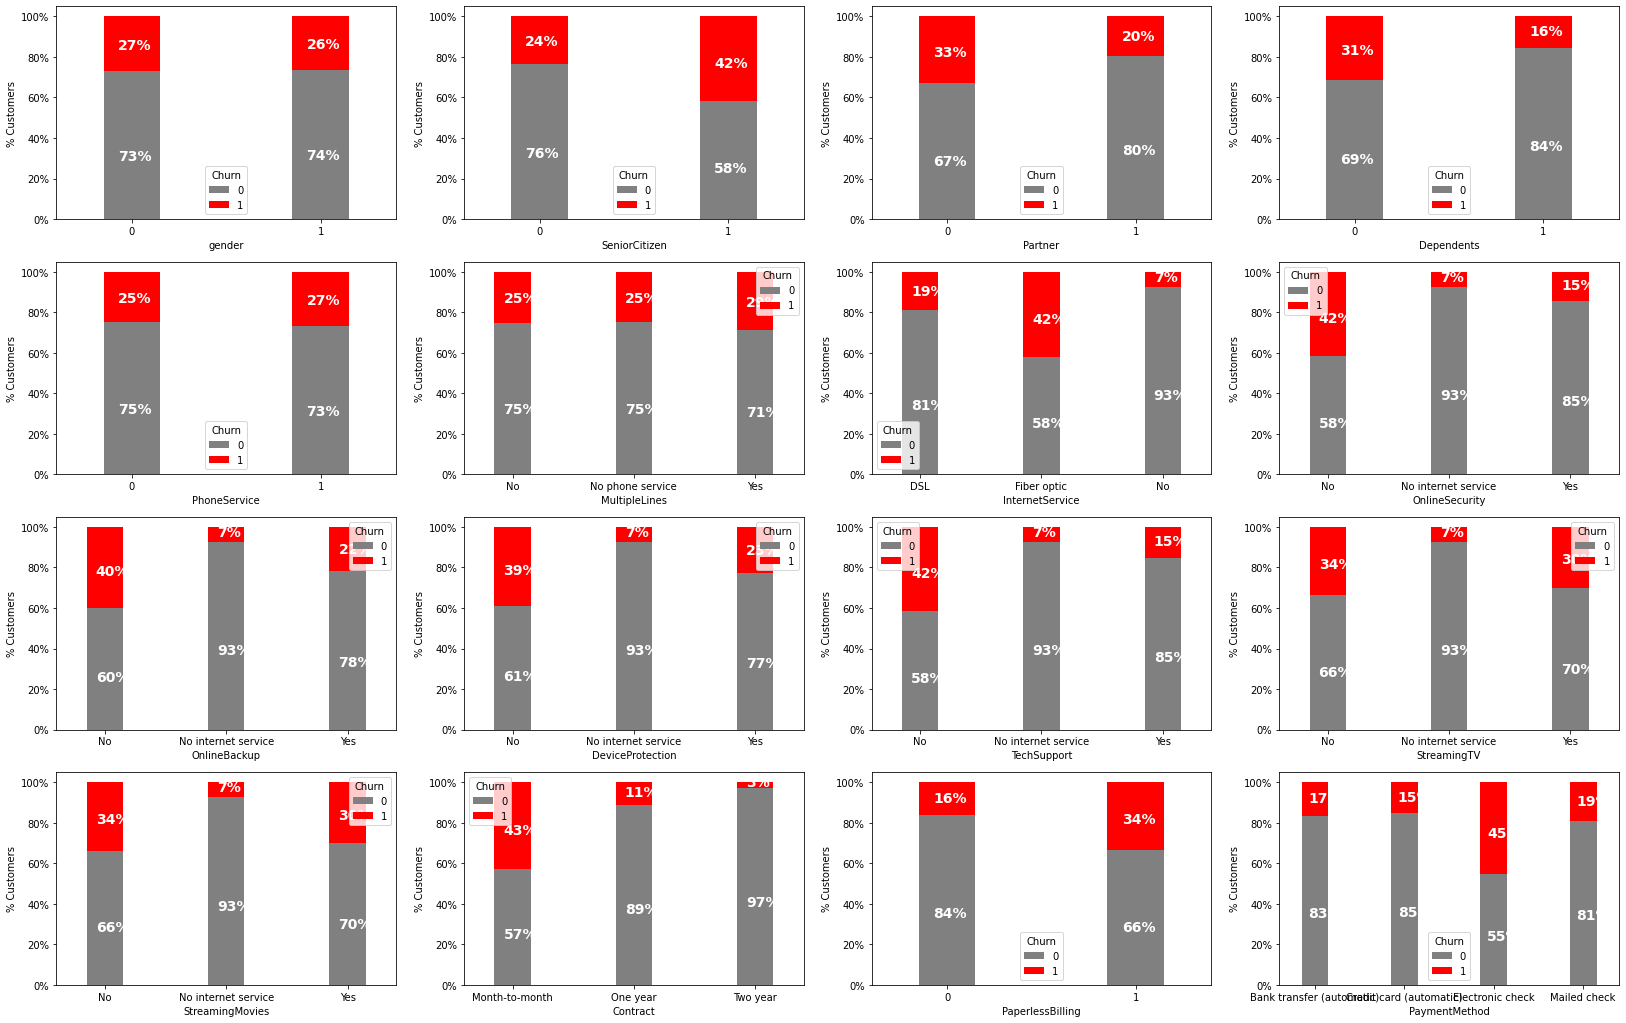

In [14]:
cat_cols=cust.drop(columns=['tenure','TotalCharges','MonthlyCharges','Churn']).columns
colors = ['grey','red']

fig, axes = plt.subplots(nrows = 4,ncols = 4,figsize = (28,18))
for i, item in enumerate(cat_cols):
    if i < 4:
        contract_churn = cust.groupby([item,'Churn']).size().unstack()
        ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar', width = 0.3, stacked = True, rot = 0, color = colors,ax=axes[0,i])
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        
        # Code to add the data labels on the stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),color = 'white',weight = 'bold',size = 14)

    elif i >=4 and i < 8:
        contract_churn = cust.groupby([item,'Churn']).size().unstack()
        ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar', width = 0.3, stacked = True, rot = 0, color = colors,ax=axes[1,i-4])
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        # Code to add the data labels on the stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),color = 'white',weight = 'bold',size = 14)
        
    elif i >=8 and i < 12:
        contract_churn = cust.groupby([item,'Churn']).size().unstack()
        ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar', width = 0.3, stacked = True, rot = 0, color = colors,ax=axes[2,i-8])
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        # Code to add the data labels on the stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),color = 'white',weight = 'bold',size = 14)
        
        
    elif i >=12 and i < 16:
        contract_churn = cust.groupby([item,'Churn']).size().unstack()
        ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar', width = 0.3, stacked = True, rot = 0, color = colors,ax=axes[3,i-12])
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        # Code to add the data labels on the stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),color = 'white',weight = 'bold',size = 14)

    ax.set_ylabel('% Customers',size = 10)

**Observation :**

No direct relation observed between the following features and the target variable:
* PhoneService
* Gender
* StreamingTV
* MultipleLines
* InternetService

In [15]:
#dropping the non important variables
cust_imp=cust.drop(columns = ['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService','Churn'])
Churn=cust['Churn']
pred=pd.get_dummies(cust_imp)

## d. Multicolinearity among predictors

<AxesSubplot:>

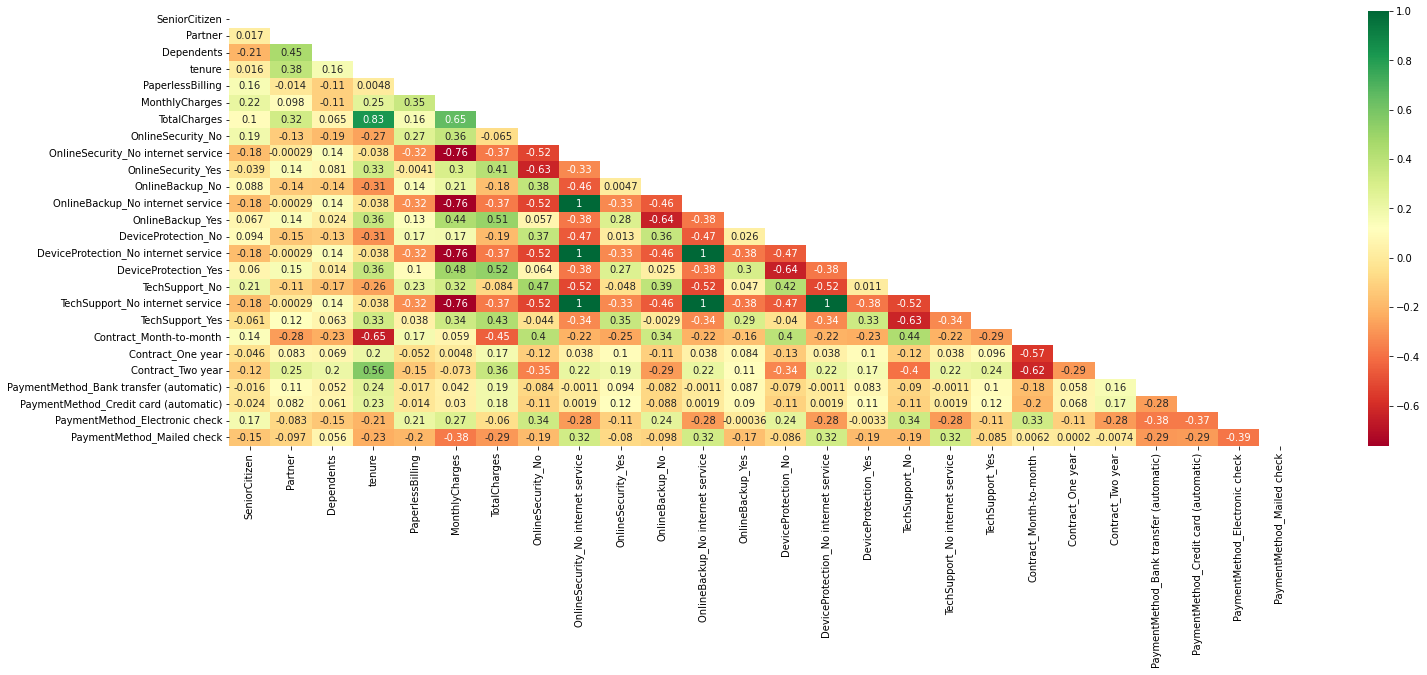

In [16]:
#the heat map of the correlation
plt.figure(figsize=(24,8))
corr = pred.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdYlGn')

**Observation :**
* We observe complete correlation between all the services having No Internet services and hence we will drop these variables.
* TotalCharges has a strong corelation with tenure and MonthlyCharges
* MonthlyCharges & TotalCharges are highly correlated with multiple phone services
* Partners and Dependents seems to be some what correlated

**Action :**

Dropping some of the highly correlated categorical variables.

In [17]:
#dropping dependent dummy variables
pred.drop(columns=['OnlineSecurity_No internet service', 'TechSupport_No internet service', 'OnlineBackup_No internet service','DeviceProtection_No internet service',
                   'Contract_Two year', 'OnlineBackup_No','DeviceProtection_Yes','PaymentMethod_Bank transfer (automatic)'],inplace=True)

## e. OLS Regression
**Ordinary Least Squares regression (OLS)** is a common technique for estimating coefficients of linear regression equations which describe the relationship between one or more independent quantitative variables and a dependent variable (simple or multiple linear regression).

In [18]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(Churn, pred).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Churn   R-squared (uncentered):                   0.468
Model:                            OLS   Adj. R-squared (uncentered):              0.466
Method:                 Least Squares   F-statistic:                              362.6
Date:                Fri, 14 Oct 2022   Prob (F-statistic):                        0.00
Time:                        04:46:53   Log-Likelihood:                         -3101.8
No. Observations:                7032   AIC:                                      6238.
Df Residuals:                    7015   BIC:                                      6354.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
SeniorCitizen                             0.0511      0.013      3.920      0.000       0.026       0.077
Partner                                   0.0040      0.011      0.366      0.714      -0.017       0.025
Dependents                               -0.0143      0.011     -1.253      0.210      -0.037       0.008
tenure                                   -0.0067      0.026     -0.258      0.797      -0.058       0.045
PaperlessBilling                          0.0542      0.010      5.434      0.000       0.035       0.074
MonthlyCharges                            0.5256      0.035     14.986      0.000       0.457       0.594
TotalCharges                             -0.4804      0.051     -9.414      0.000      -0.580      -0.380
OnlineSecurity_No                         0.0348      0.012      3.006      0.003       0.012       0.057
OnlineSecurity_Yes                       -0.0460      0.012     -3.969      0.000      -0.069      -0.023
OnlineBackup_Yes                         -0.0445      0.011     -3.926      0.000      -0.067      -0.022
DeviceProtection_No                       0.0205      0.012      1.762      0.078      -0.002       0.043
TechSupport_No                            0.0324      0.012      2.795      0.005       0.010       0.055
TechSupport_Yes                          -0.0436      0.012     -3.743      0.000      -0.066      -0.021
Contract_Month-to-month                   0.1240      0.014      8.979      0.000       0.097       0.151
Contract_One year                        -0.0054      0.013     -0.414      0.679      -0.031       0.020
PaymentMethod_Credit card (automatic)     0.0148      0.013      1.146      0.252      -0.011       0.040
PaymentMethod_Electronic check            0.0920      0.013      7.166      0.000       0.067       0.117
PaymentMethod_Mailed check                0.0266      0.013      2.119      0.034       0.002       0.051
==============================================================================
Omnibus:                      340.281   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              362.085
Skew:                           0.529   Prob(JB):                     2.37e-79
Kurtosis:                       2.661   Cond. No.                     6.97e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 4.48e-28. This might indicate that there are
strong multic

**Observation :**

We will considering the significance value of 0.05.

Most of the predictor variables have p-value less than 0.05 and hence they are significant features.

## f. Data Balancing
In order to cope with unbalanced data, we will be performing **Oversampling**, i.e. increase the minority samples of the target variable to the majority samples.
For data balancing, we will use imblearn.

The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the **Synthetic Minority Oversampling Technique**, or **SMOTE** for short.

In [19]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [20]:
over = SMOTE(sampling_strategy = 1)

X = pred.values
y = Churn.values

X, y = over.fit_resample(X, y)
Counter(y)

Counter({0: 5163, 1: 5163})

# 4. Modeling 

In [21]:
##Importing the libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [22]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [23]:
# Defining the Classification Model
def model(classifier,X_train,y_train,X_test,y_test):
    
    classifier.fit(X_train,y_train)
    prediction = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,X_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plot_roc_curve(classifier, X_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()
    
# Defining Evaluation Metrics
def model_evaluation(classifier,X_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(X_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(X_test)))

## Hyperparameter tuning using Optuna
Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Thanks to our define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

In [24]:
import lightgbm as lgb
import optuna
import sklearn
def objective(trial):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "n_estimators" : 1000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    return accuracy

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-10-14 04:46:56,412] A new study created in memory with name: no-name-5ec5e10e-69af-4ed7-aeeb-9e5b61c1040f
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-10-14 04:47:01,589] Trial 0 finished with value: 0.8446940356312935 and p

In [26]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.8446940356312935
  Params: 
    reg_alpha: 0.3232052703105917
    reg_lambda: 0.2666343574071113
    colsample_bytree: 0.5
    subsample: 0.6
    learning_rate: 0.006
    max_depth: 100
    num_leaves: 501
    min_child_samples: 39
    min_data_per_groups: 54


In [27]:
from lightgbm import LGBMClassifier
classifier_lgbm = LGBMClassifier(
    n_estimators=1000,
    reg_alpha= 0.035010409722998556,
    reg_lambda= 0.0026354618260279595,
    colsample_bytree= 0.3,
    subsample= 1.0,
    learning_rate= 0.02,
    max_depth= 20,
    num_leaves= 56,
    min_child_samples= 10,
    cat_smooth= 75)

Cross Validation Score :  92.86%
ROC_AUC Score :  84.47%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


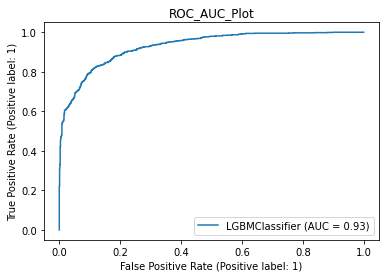

In [28]:
model(classifier_lgbm,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1041
           1       0.84      0.85      0.84      1025

    accuracy                           0.84      2066
   macro avg       0.84      0.84      0.84      2066
weighted avg       0.84      0.84      0.84      2066



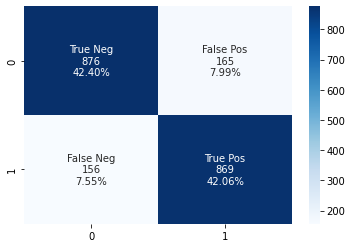

In [29]:
model_evaluation(classifier_lgbm,X_test,y_test)

## Model Evaluation
Let's understand what is meant by Precision and Recall.
* **Precision** measures the percentage of customers predicted by us to Churn that were correctly classified.
* **Recall** measures the percentage of actual customers that churned were correctly classified.

When we predict that the customers will churn, **85%** of customers actually churned. Whereas, out of all the customers that churned we were able to capture **84**% of all them correctly.

We can further tune our models to be more precise or have a better recall based on the business requirement.

# 5. Summary
Since we are predicting customers that will churn, we have achieved a good F1 score of 85%,

* Based on the customer info, **Senior Citizens** and **Customers without partners and dependent** are more likely to churn.
* Retention Strategies must be made for the **new customers**, as once the customers cross the **20 months** mark they are less likely to churn.
* An affordable entry point needs to be provided to the new customers, as generally customers are more likely to churn when the **Monthly Charges crosses the 70** mark.
* Customers paying through **Electronic Checks** and having **Paperless Billing** have a higher tendency to churn.
* Customers having no **Online Security, Online Backup, Device Protection and Tech Support** are very likely to churn.

#### If you found this notebook helpful or you just liked it , some **upvotes** would be very much appreciated

# License

**References :**
* https://scikit-learn.org/stable/
* https://lightgbm.readthedocs.io/en/v3.3.2/
* https://optuna.org/

Copyright (c) 2022 chakraborty-arnab

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.